# EDA for NLP classification

In [8]:
import pandas as pd
import numpy as np
import nltk
# nltk.download()

In [9]:
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

Full dataset contains 500k+ observations and was way too large for our purposes. Instead, we read-in 3 samples of 10,000 observations each (spoilers and non-spoilers), to train our models.

In [10]:
# Samples with the same seed taken from larger dataset
df_spoiler_1 = pd.read_csv('sampled_spoilers1.csv')
df_spoiler_2 = pd.read_csv('sampled_spoilers2.csv')
df_spoiler_3 = pd.read_csv('sampled_spoilers3.csv')

df_nonspoiler_1 = pd.read_csv('sampled_nonspoilers1.csv')
df_nonspoiler_2 = pd.read_csv('sampled_nonspoilers2.csv')
df_nonspoiler_3 = pd.read_csv('sampled_nonspoilers3.csv')

In [11]:
df_nonspoiler_3.shape

(10000, 8)

# TO COMPUTE: Null Accuracy of assuming all reviews contain spoilers

In [12]:
# null_accuracy = (df_spoiler.shape[0])/(df_nospoiler.shape[0])
# round(null_accuracy,4)

In [13]:
df_spoiler_1.head(1)

,Unnamed: 0,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,309291,1 February 2003,tt0167261,ur2201918,True,First of all if you haven't seen the movie (or...,10,review of THE TWO TOWERS spoiler


#### Isolate Review text

In [14]:
def cleaner(review):
    
    """
    Breaks up a review into tokens using the nltk package
    """    
    
    # Divide sentences into words
    words = word_tokenize(review)
    
    # Remove punctuation
    tokens = [word for word in words if word.isalpha()]
    
    # Un-capitalize all words
    tokens_lowercase = [token.lower() for token in tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # ...including the following which appear often in both classes
    new_stopwords = ['movie', 'file', 'one', 'story']
    for w in new_stopwords:
        stop_words.add(w)
    final_words = [word for word in tokens_lowercase if not word in stop_words]
    
    return final_words

### Clean and tokenize

#### *** This function takes a long time to run on the full dataset (~5mins) ***

In [15]:
df_spoiler_1['review_words'] = df_spoiler_1.review_text.apply(cleaner)
df_spoiler_2['review_words'] = df_spoiler_2.review_text.apply(cleaner)
df_spoiler_3['review_words'] = df_spoiler_3.review_text.apply(cleaner)

df_nonspoiler_1['review_words'] = df_nonspoiler_1.review_text.apply(cleaner)
df_nonspoiler_2['review_words'] = df_nonspoiler_2.review_text.apply(cleaner)
df_nonspoiler_3['review_words'] = df_nonspoiler_3.review_text.apply(cleaner)

### Add feature "Review Length"

In [16]:
df_spoiler_1['review_length'] = df_spoiler_1.review_words.apply(len)
df_spoiler_2['review_length'] = df_spoiler_2.review_words.apply(len)
df_spoiler_3['review_length'] = df_spoiler_3.review_words.apply(len)

df_nonspoiler_1['review_length'] = df_nonspoiler_1.review_words.apply(len)
df_nonspoiler_2['review_length'] = df_nonspoiler_2.review_words.apply(len)
df_nonspoiler_3['review_length'] = df_nonspoiler_3.review_words.apply(len)

In [17]:
df_nonspoiler_1.head(1)

,Unnamed: 0,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,review_words,review_length
0,420187,22 February 2008,tt0467406,ur2449095,False,This is a hugely enjoyable film. Juno is a hig...,7,Dealing with stuff way past her maturity,"[hugely, enjoyable, film, juno, high, school, ...",116


In [18]:
# remove unneccessary columns
drop_columns = ['review_date', 'user_id', 'review_text', 'rating', 'review_summary']

# df_spoiler_1.drop(drop_columns, axis=1, inplace=True)
# df_spoiler_2.drop(drop_columns, axis=1, inplace=True)
# df_spoiler_3.drop(drop_columns, axis=1, inplace=True)

# df_nonspoiler_1.drop(drop_columns, axis=1, inplace=True)
# df_nonspoiler_2.drop(drop_columns, axis=1, inplace=True)
# df_nonspoiler_3.drop(drop_columns, axis=1, inplace=True)

In [19]:
# convert T/F to 1/0
df_spoiler_1.is_spoiler = df_spoiler_1.is_spoiler.astype(int)
df_spoiler_2.is_spoiler = df_spoiler_2.is_spoiler.astype(int)
df_spoiler_3.is_spoiler = df_spoiler_3.is_spoiler.astype(int)

df_nonspoiler_1.is_spoiler = df_nonspoiler_1.is_spoiler.astype(int)
df_nonspoiler_2.is_spoiler = df_nonspoiler_2.is_spoiler.astype(int)
df_nonspoiler_3.is_spoiler = df_nonspoiler_3.is_spoiler.astype(int)

In [20]:
df_spoiler_1[['review_length']].head(1)

,review_length
0,122


#### Lemmetize Reviews

In [21]:
processed_data_sp1 = list(df_spoiler_1.review_words)
processed_data_sp2 = list(df_spoiler_2.review_words)
processed_data_sp3 = list(df_spoiler_3.review_words)

processed_data_ns1 = list(df_nonspoiler_1.review_words)
processed_data_ns2 = list(df_nonspoiler_2.review_words)
processed_data_ns3 = list(df_nonspoiler_3.review_words)

In [22]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer()

In [23]:
lemmatized_output_sp1 = []
lemmatized_output_sp2 = []
lemmatized_output_sp3 = []

lemmatized_output_ns1 = []
lemmatized_output_ns2 = []
lemmatized_output_ns3 = []

for listy in processed_data_sp1:
    lemmed = ' '.join([lemmatizer.lemmatize(w, pos='v') for w in listy])
    lemmatized_output_sp1.append(lemmed)
    
for listy in processed_data_sp2:
    lemmed = ' '.join([lemmatizer.lemmatize(w, pos='v') for w in listy])
    lemmatized_output_sp2.append(lemmed)
    
for listy in processed_data_sp3:
    lemmed = ' '.join([lemmatizer.lemmatize(w, pos='v') for w in listy])
    lemmatized_output_sp3.append(lemmed)
    
for listy in processed_data_ns1:
    lemmed = ' '.join([lemmatizer.lemmatize(w, pos='v') for w in listy])
    lemmatized_output_ns1.append(lemmed)
    
for listy in processed_data_ns2:
    lemmed = ' '.join([lemmatizer.lemmatize(w, pos='v') for w in listy])
    lemmatized_output_ns2.append(lemmed)
    
for listy in processed_data_ns3:
    lemmed = ' '.join([lemmatizer.lemmatize(w, pos='v') for w in listy])
    lemmatized_output_ns3.append(lemmed)

In [24]:
# Lemmatized words of 10,000 review samples
X_lem_sp1 = lemmatized_output_sp1
X_lem_sp2 = lemmatized_output_sp2
X_lem_sp3 = lemmatized_output_sp3

X_lem_ns1 = lemmatized_output_ns1
X_lem_ns2 = lemmatized_output_ns2
X_lem_ns3 = lemmatized_output_ns3

print(len(X_lem_ns1))

10000


In [25]:
X_lem = [X_lem_sp1, X_lem_sp2, X_lem_sp3, X_lem_ns1, X_lem_ns2, X_lem_ns3]

#### Tokenize using TF-IDF Vectorizer

In [26]:
tfidf_sp1 = TfidfVectorizer()
tfidf_sp2 = TfidfVectorizer()
tfidf_sp3 = TfidfVectorizer()

tfidf_ns1 = TfidfVectorizer()
tfidf_ns2 = TfidfVectorizer()
tfidf_ns3 = TfidfVectorizer()

In [27]:
# This will run for 45-60 seconds
tokenized_reviews_sp1 = tfidf_sp1.fit_transform(X_lem_sp1)
tokenized_reviews_sp2 = tfidf_sp2.fit_transform(X_lem_sp2)
tokenized_reviews_sp3 = tfidf_sp3.fit_transform(X_lem_sp3)

tokenized_reviews_ns1 = tfidf_ns1.fit_transform(X_lem_ns1)
tokenized_reviews_ns2 = tfidf_ns2.fit_transform(X_lem_ns2)
tokenized_reviews_ns3 = tfidf_ns3.fit_transform(X_lem_ns3)

In [28]:
# tokenized_reviews_sp1

tokenized_reviews_ns1

<10000x35059 sparse matrix of type '<class 'numpy.float64'>'
	with 877838 stored elements in Compressed Sparse Row format>

#### Merge length and TF-IDF dfs

In [30]:
df_tokenized_reviews_sp1 = pd.DataFrame(tokenized_reviews_sp1.toarray(), columns=tfidf_sp1.get_feature_names())

In [31]:
df_sp1 = df_tokenized_reviews_sp1.merge(df_spoiler_1[['review_length']], left_index=True, right_index=True)

In [32]:
df_tokenized_reviews_sp2 = pd.DataFrame(tokenized_reviews_sp2.toarray(), columns=tfidf_sp2.get_feature_names())

In [33]:
df_sp2 = df_tokenized_reviews_sp2.merge(df_spoiler_2[['review_length']], left_index=True, right_index=True)

In [34]:
df_tokenized_reviews_sp3 = pd.DataFrame(tokenized_reviews_sp3.toarray(), columns=tfidf_sp3.get_feature_names())

In [35]:
df_sp3 = df_tokenized_reviews_sp3.merge(df_spoiler_3[['review_length']], left_index=True, right_index=True)

In [36]:
df_tokenized_reviews_ns1 = pd.DataFrame(tokenized_reviews_ns1.toarray(), columns=tfidf_ns1.get_feature_names())

In [37]:
df_ns1 = df_tokenized_reviews_ns1.merge(df_nonspoiler_1[['review_length']], left_index=True, right_index=True)

In [38]:
df_tokenized_reviews_ns2 = pd.DataFrame(tokenized_reviews_ns2.toarray(), columns=tfidf_ns2.get_feature_names())

In [39]:
df_ns2 = df_tokenized_reviews_ns2.merge(df_nonspoiler_2[['review_length']], left_index=True, right_index=True)

In [40]:
df_tokenized_reviews_ns3 = pd.DataFrame(tokenized_reviews_ns3.toarray(), columns=tfidf_ns3.get_feature_names())

In [41]:
df_ns3 = df_tokenized_reviews_ns3.merge(df_nonspoiler_3[['review_length']], left_index=True, right_index=True)

## Modeling

In [42]:
target_sp1 = df_spoiler_1.is_spoiler
target_sp2 = df_spoiler_2.is_spoiler
target_sp3 = df_spoiler_3.is_spoiler

target_ns1 = df_nonspoiler_1.is_spoiler
target_ns2 = df_nonspoiler_2.is_spoiler
target_ns3 = df_nonspoiler_3.is_spoiler

## Naive Bayes

In [43]:
# X = pd.DataFrame(X_lem, data_sample.review_length).reset_index()
# X.columns = ['review_length', 'X_lem']


In [44]:
# X.head()

In [45]:
# Test/Train split lemmatized 
X_train_sp1, X_test_sp1, y_train_sp1, y_test_sp1 = train_test_split(df_sp1, target_sp1, test_size=0.20, random_state=1)
X_train_sp2, X_test_sp2, y_train_sp2, y_test_sp2 = train_test_split(df_sp2, target_sp2, test_size=0.20, random_state=1)
X_train_sp3, X_test_sp3, y_train_sp3, y_test_sp3 = train_test_split(df_sp3, target_sp3, test_size=0.20, random_state=1)

X_train_ns1, X_test_ns1, y_train_ns1, y_test_ns1 = train_test_split(df_ns1, target_ns1, test_size=0.20, random_state=1)
X_train_ns2, X_test_ns2, y_train_ns2, y_test_ns2 = train_test_split(df_ns2, target_ns2, test_size=0.20, random_state=1)
X_train_ns3, X_test_ns3, y_train_ns3, y_test_ns3 = train_test_split(df_ns3, target_ns3, test_size=0.20, random_state=1)


#### Naive Bayes classifier

In [46]:
nb_classifier = MultinomialNB()

In [47]:
nb_classifier.fit(X_train_sp1, y_train_sp1)
nb_train_preds = nb_classifier.predict(X_train_sp1)
nb_test_preds = nb_classifier.predict(X_test_sp1)

In [48]:
nb_train_score = accuracy_score(y_train_sp1, nb_train_preds)
nb_test_score = accuracy_score(y_test_sp1, nb_test_preds)

In [49]:
print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)

Multinomial Naive Bayes
Training Accuracy: 1.0 		 Testing Accuracy: 1.0

----------------------------------------------------------------------


#### Confusion Matrix (Naive Bayes Model)

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      9887
           1       0.66      0.71      0.68     10113

    accuracy                           0.67     20000
   macro avg       0.67      0.67      0.67     20000
weighted avg       0.67      0.67      0.67     20000



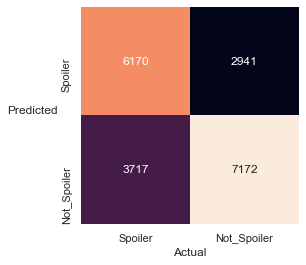

In [71]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Spoiler', 'Not_Spoiler'], yticklabels=['Spoiler', 'Not_Spoiler'])
plt.xlabel('Actual')
plt.ylabel('Predicted', rotation='horizontal', ha='right');
print(classification_report(y_test, nb_test_preds))

#### Confirming labels

In [215]:
# Checking test labels (Actual)
unique, counts = np.unique(y_test, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 29966]
 [    1 30034]]


In [220]:
# Checking test labels (Predicted)
unique, counts = np.unique(nb_test_preds, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 28149]
 [    1 31851]]


## Naive Bayes "w/o Length"

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, target_sample, test_size=0.20, random_state=1)

#### Naive Bayes classifier

In [231]:
nb_classifier = MultinomialNB()

In [234]:

nb_classifier.fit(X_train, y_train)
nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

ValueError: Expected 2D array, got 1D array instead:
array=[189 132 134 ... 143 120 163].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [84]:
nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)

In [85]:
print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)

Multinomial Naive Bayes
Training Accuracy: 0.7146 		 Testing Accuracy: 0.6715

----------------------------------------------------------------------


#### Confusion Matrix (Naive Bayes Model)

              precision    recall  f1-score   support

           0       0.68      0.64      0.66     29966
           1       0.66      0.70      0.68     30034

    accuracy                           0.67     60000
   macro avg       0.67      0.67      0.67     60000
weighted avg       0.67      0.67      0.67     60000



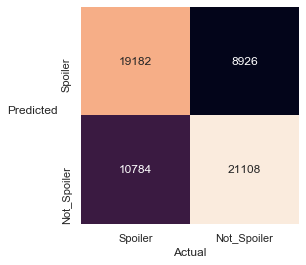

In [86]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Spoiler', 'Not_Spoiler'], yticklabels=['Spoiler', 'Not_Spoiler'])
plt.xlabel('Actual')
plt.ylabel('Predicted', rotation='horizontal', ha='right');
print(classification_report(y_test, nb_test_preds))

In [69]:
mat

array([[19182, 10784],
       [ 8926, 21108]])

## (MISC. cells below)

In [79]:
df[no_spoiler].is_spoiler.value_counts()

0    422989
Name: is_spoiler, dtype: int64

### Stemming and Lemming

In [39]:
# Instantiating objects
ps = PorterStemmer()


#### Stemming

In [41]:
def stemmer(review):
    stemmed_review = [ps.stem(w) for w in review]
    return stemmed_review

In [47]:
stemmer(final_words)[:10]

['oscar',
 'year',
 'shawshank',
 'redempt',
 'written',
 'direct',
 'frank',
 'darabont',
 'novella',
 'rita']

#### Lemming

In [44]:
def lemmer(review):
    lemmed_review = [lemmatizer.lemmatize(w) for w in review]
    return lemmed_review

In [67]:
len(lemmer(final_words))

418

In [1]:
final_words[:25]

NameError: name 'final_words' is not defined